## **1. Import Library**

Mengimport library-library yang dibutuhkan untuk membangun model

In [ ]:
# Library pendukung
import os, json, random, warnings, math, itertools, io, base64, pathlib, time
warnings.filterwarnings("ignore")

# Olah dan Manipulasi Data
import numpy as np
import pandas as pd

# Visualisasi
import altair as alt

# Model ML
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

# Evaluasi Model
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve, auc,
                             precision_recall_curve, average_precision_score)

# Image dan Display
from PIL import Image, ImageOps
from IPython.display import display


2025-09-23 02:44:12.108856: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758595452.372740      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758595452.434059      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## **2. Load Dataset**

Menetapkan path dataset dan parameter dasar (IMG_SIZE=224×224, BATCH_SIZE=16, SEED=42, VAL_SPLIT=0.15), lalu memuat data dengan `image_dataset_from_directory`: **train** dan **val** diambil dari folder TRAIN menggunakan `validation_split`/`subset`, sedangkan **test** dari folder TEST (tanpa shuffle). Label diinferensikan otomatis, ukuran gambar di-resize ke 224×224. Membuat pemetaan kelas (`CLASS_TO_IDX`/`IDX_TO_CLASS`) dari `class_names`. Meningkatkan performa pipeline dengan `cache()`, `prefetch(AUTOTUNE)`, dan `shuffle(1000)` khusus train. Terakhir, menyematkan `class_names` ke setiap dataset agar konsisten saat evaluasi dan ekspor label.

In [ ]:
# Path ke folder dataset
DATASET_ROOT = "waste-classification-data/DATASET"
TRAIN_DIR    = os.path.join(DATASET_ROOT, "TRAIN")
TEST_DIR     = os.path.join(DATASET_ROOT, "TEST")

# Setup Config parameter
IMG_SIZE    = (224, 224)
BATCH_SIZE  = 16
SEED        = 42
VAL_SPLIT   = 0.15  

# train config
train_raw = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=VAL_SPLIT,
    subset='training'
)

# val config
val_raw = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=VAL_SPLIT,
    subset='validation'
)

# test config
test_raw = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    labels='inferred',
    label_mode='int',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_raw.class_names
CLASS_TO_IDX = {name: i for i, name in enumerate(class_names)}
IDX_TO_CLASS = {i: name for name, i in CLASS_TO_IDX.items()}

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_raw.cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds   = val_raw.cache().prefetch(AUTOTUNE)
test_ds  = test_raw.cache().prefetch(AUTOTUNE)

train_ds.class_names = class_names
val_ds.class_names   = class_names
test_ds.class_names  = class_names

Found 22564 files belonging to 2 classes.
Using 19180 files for training.


I0000 00:00:1758595473.552828      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758595473.553652      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 22564 files belonging to 2 classes.
Using 3384 files for validation.
Found 2513 files belonging to 2 classes.


## **3. EDA**

Menghitung distribusi kelas per split: fungsi `count_by_class` men-*unbatch* dataset, mengumpulkan label (`yb`), mengonversinya ke `numpy`, lalu menghitung frekuensi tiap kelas (mengacu `IDX_TO_CLASS`/`class_names`). Hasil dihimpun sebagai daftar baris berisi `split`, `label`, dan `count` untuk **train/val/test**, digabung menjadi `eda_rows` dan akhirnya dibentuk `eda_df` (DataFrame) sebagai ringkasan jumlah sampel per kelas di setiap split.

In [4]:
def count_by_class(ds, split_name):
    ys = []
    for xb, yb in ds.unbatch():
        ys.append(int(yb.numpy()))
    ys = np.array(ys)
    counts = {IDX_TO_CLASS[i]: int((ys==i).sum()) for i in range(len(class_names))}
    rows = [{"split": split_name, "label": k, "count": v} for k,v in counts.items()]
    return rows

eda_rows = []
eda_rows += count_by_class(train_ds, "train")
eda_rows += count_by_class(val_ds, "val")
eda_rows += count_by_class(test_ds, "test")
eda_df = pd.DataFrame(eda_rows)
eda_df

,split,label,count
0,train,O,10699
1,train,R,8481
2,val,O,1866
3,val,R,1518
4,test,O,1401
5,test,R,1112


Membuat bar chart untuk menampilkan jumlah sampel per kelas (O/R) pada tiap split (train/val/test)

In [5]:
order_label = ['O','R']
order_split = ['train','val','test']

max_count = int(eda_df['count'].max())
step = 1000
tick_vals = list(range(0, ((max_count // step) + 2) * step, step))

base = alt.Chart(eda_df).encode(
    x=alt.X('label:N', title='Kelas', sort=order_label, axis=alt.Axis(labelAngle=0)),
    xOffset=alt.X('split:N', sort=order_split),
    tooltip=['label','split','count']
)

chart_counts = (
  base.mark_bar(cornerRadiusTopLeft=4, cornerRadiusTopRight=4)
  .encode(
      y=alt.Y('count:Q',
              title='Jumlah',
              axis=alt.Axis(format=",.0f", values=tick_vals),

      ),
      color=alt.Color('split:N', sort=order_split, title='Split')
  )
  .properties(width=520, height=520, title='Distribusi Kelas (O vs R) per Split — Counts')
)

text_counts = (
  base.mark_text(dy=-8, fontWeight='bold', opacity=0.85)
  .encode(
      y='count:Q',
      text=alt.Text('count:Q', format=',') 
  )
)

(chart_counts + text_counts)

alt.LayerChart(...)

Menampilkan sample gambar O dan R dari dataset.

alt.LayerChart(...)
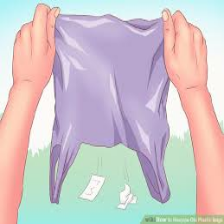
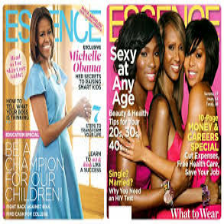
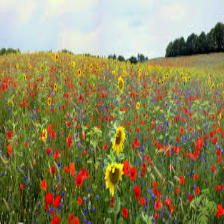
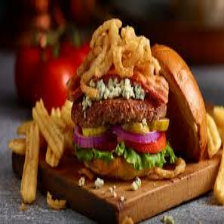
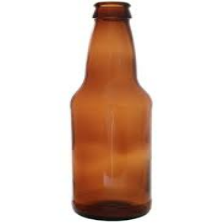
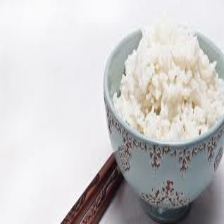
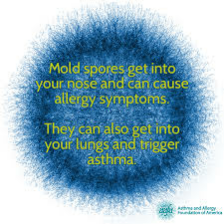
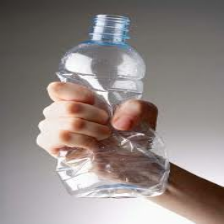

In [6]:
N_SHOW = 8
sample_images = []
for xb, yb in train_ds.unbatch().take(N_SHOW):
    img = xb.numpy().astype("uint8")
    label = IDX_TO_CLASS[int(yb.numpy())]
    sample_images.append((img, label))

def img_to_data_uri(arr):
    im = Image.fromarray(arr)
    buf = io.BytesIO()
    im.save(buf, format="PNG")
    b64 = base64.b64encode(buf.getvalue()).decode("ascii")
    return f"data:image/png;base64,{b64}"

records = []
grid_cols = 4
for i, (img, label) in enumerate(sample_images):
    records.append({
        "id": i,
        "label": label,
        "col": i % grid_cols,
        "row": i // grid_cols,
        "url": img_to_data_uri(img),
    })
df = pd.DataFrame(records)

cell_w, cell_h = 160, 160
grid_rows = int(np.ceil(len(df)/grid_cols))

bg = (
    alt.Chart(df)
    .mark_rect(stroke="#ddd", fill="white")
    .encode(
        x=alt.X("col:O", axis=None),
        y=alt.Y("row:O", sort="descending", axis=None)
    )
)

imgs = (
    alt.Chart(df)
    .mark_image()
    .encode(
        x=alt.X("col:O", axis=None, scale=alt.Scale(paddingInner=0, paddingOuter=0)),
        y=alt.Y("row:O", sort="descending", axis=None, scale=alt.Scale(paddingInner=0, paddingOuter=0)),
        url="url:N",
        tooltip=["id","label"]
    )
)

labels = (
    alt.Chart(df)
    .mark_text(
        align="left", baseline="top", dx=6, dy=6, fontWeight="bold"
    )
    .encode(
        x=alt.X("col:O", axis=None),
        y=alt.Y("row:O", sort="descending", axis=None),
        text="label:N",
        color=alt.Color("label:N", scale=alt.Scale(domain=["O","R"], range=["#10b981","#3b82f6"]))
    )
)

gallery = (bg + imgs + labels).properties(
    width=grid_cols * cell_w,
    height=grid_rows * cell_h,
    title="Sampel Gambar Train (O vs R)"
).configure_view(
    strokeWidth=0 
)

gallery

## **4. Data Augmentation**

Menerapkan **augmentasi ringan** (flip, rotasi 0.05, zoom 0.1) dan **MixUp** (α=0.2, Beta) pada batch train: gambar dicampur acak antar-sampel, label diubah jadi **soft labels** (one-hot terinterpolasi); pipeline `train_ds → augment → (opsional) mixup` diproses paralel dengan `AUTOTUNE`.

In [7]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
], name="augment")

USE_MIXUP = True
MIXUP_ALPHA = 0.2

def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)

@tf.function
def mixup(batch_x, batch_y, alpha=MIXUP_ALPHA):
    batch_size = tf.shape(batch_x)[0]
    beta = sample_beta_distribution(batch_size, alpha, alpha)
    x_weight = tf.reshape(beta, (batch_size, 1, 1, 1))
    y_weight = tf.reshape(beta, (batch_size, 1))
    indices = tf.random.shuffle(tf.range(batch_size))
    mixed_x = batch_x * x_weight + tf.gather(batch_x, indices) * (1 - x_weight)
    mixed_y = tf.cast(tf.one_hot(tf.cast(batch_y, tf.int32), depth=2), tf.float32)
    mixed_y = mixed_y * y_weight + tf.gather(mixed_y, indices) * (1 - y_weight)
    return mixed_x, mixed_y

def mixup_map_fn(images, labels):
    return mixup(images, labels)

train_aug = train_ds.map(lambda x,y: (data_augmentation(x), y), num_parallel_calls=AUTOTUNE)
if USE_MIXUP:
    train_aug = train_aug.map(mixup_map_fn, num_parallel_calls=AUTOTUNE)

## **5. Model Building**

* **ECALayer**: merata-ratakan fitur per kanal, lewatkan ke Conv1D kecil + sigmoid untuk bikin bobot kanal, lalu dikalikan balik ke fitur—intinya menonjolkan kanal yang penting.
* **DSResECA_block**: urutannya **1×1 expand → 3×3 depthwise → 1×1 project → ECA → residual skip** (pakai shortcut proyek kalau dimensi berubah) + ReLU; ada L2 biar nggak overfitting.
* **build_model**: input 224×224 di-rescale /255, **stem** conv stride-2, lanjut 4 **stage** bertingkat (beberapa blok, sebagian downsample). Lebar & kedalaman bisa di-scale (`width_mult`, `depth_mult`). Head-nya **GAP → Dropout → Dense softmax(2)**. Terakhir, model dibuat dan ditampilkan `summary()`.

In [ ]:
class ECALayer(layers.Layer):
    def __init__(self, gamma=2, b=1, **kwargs):
        super().__init__(**kwargs)
        self.gamma = gamma
        self.b = b

    def build(self, input_shape):
        channels = int(input_shape[-1])
        t = int(abs((math.log2(channels) + self.b) / self.gamma))
        k = t if t % 2 else t + 1
        k = max(3, k)
        self.conv1d = layers.Conv1D(1, kernel_size=k, padding="same", use_bias=False)
        super().build(input_shape)

    def call(self, x):
        y = tf.reduce_mean(x, axis=[1,2])      # (B, C)
        y = tf.expand_dims(y, -1)              # (B, C, 1)
        y = self.conv1d(y)
        y = tf.nn.sigmoid(y)
        y = tf.squeeze(y, -1)                  # (B, C)
        y = tf.reshape(y, (-1, 1, 1, tf.shape(y)[-1]))
        return x * y

def DSResECA_block(x, out_ch, stride=1, expansion=3.0, wd=1e-5, name=None):
    in_ch = x.shape[-1]

    # 1) Expand (1x1)
    expanded = int(round(out_ch * expansion))
    y = layers.Conv2D(expanded, 1, padding="same", use_bias=False,
                      kernel_regularizer=regularizers.l2(wd))(x)
    y = layers.BatchNormalization()(y)
    y = layers.ReLU()(y)

    # 2) Depthwise 3x3
    y = layers.DepthwiseConv2D(3, strides=stride, padding="same", use_bias=False,
                               depthwise_regularizer=regularizers.l2(wd))(y)
    y = layers.BatchNormalization()(y)
    y = layers.ReLU()(y)

    # 3) Project (1x1)
    y = layers.Conv2D(out_ch, 1, padding="same", use_bias=False,
                      kernel_regularizer=regularizers.l2(wd))(y)
    y = layers.BatchNormalization()(y)

    # 4) ECA attention
    y = ECALayer(name=None if name is None else name + "_eca")(y)

    # 5) Residual 
    if (stride == 1) and (in_ch == out_ch):
        shortcut = x
    else:
        shortcut = layers.Conv2D(out_ch, 1, strides=stride, padding="same", use_bias=False,
                                 kernel_regularizer=regularizers.l2(wd))(x)
        shortcut = layers.BatchNormalization()(shortcut)

    y = layers.Add()([y, shortcut])
    y = layers.ReLU(name=name)(y)
    return y

def build_model(input_shape=(224,224,3), num_classes=2,
                width_mult=1.25,    
                depth_mult=1.0,     
                expansion=3.0,      
                wd=1e-5,           
                dropout=0.30):

    def C(c):  # helper: scale channel & bulatkan ke kelipatan 8
        cc = int(round(c * width_mult))
        return max(8, (cc + 7) // 8 * 8)

    def N(n):  # helper: scale depth
        return max(1, int(round(n * depth_mult)))

    inputs = layers.Input(shape=input_shape)
    x = layers.Rescaling(1./255)(inputs)

    # Stem
    x = layers.Conv2D(C(64), 3, strides=2, padding="same", use_bias=False,
                      kernel_regularizer=regularizers.l2(wd))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Stage configs: (out_ch, n_blocks, first_stride)
    stages = [
        (C(64),  N(2), 1),  # tetap resolusi
        (C(128), N(3), 2),  # downsample
        (C(192), N(3), 2),  # downsample
        (C(256), N(2), 2),  # downsample
    ]

    for si, (ch, n, s) in enumerate(stages):
        # blok pertama dengan stride s
        x = DSResECA_block(x, ch, stride=s, expansion=expansion, wd=wd, name=f"stage{si+1}_b1")
        # sisa blok stride=1
        for bi in range(2, n+1):
            x = DSResECA_block(x, ch, stride=1, expansion=expansion, wd=wd, name=f"stage{si+1}_b{bi}")

    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs, name="DSResECA_Scaled")
    return model

model = build_model(input_shape=IMG_SIZE + (3,), num_classes=2,
                    width_mult=1.25, depth_mult=1.0, expansion=3.0, wd=1e-5, dropout=0.30)
model.summary()

Model: "DSResECA_Scaled"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      2,160 │ rescaling[0][0]   │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        320 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 112, 112,  │     19,200 │ re_lu[0][0]       │
│                     │ 240)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        960 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 240)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 240)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d    │ (None, 112, 112,  │      2,160 │ re_lu_1[0][0]     │
│ (DepthwiseConv2D)   │ 240)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        960 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 240)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 240)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 112, 112,  │     19,200 │ re_lu_2[0][0]     │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        320 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_b1_eca       │ (None, 112, 112,  │          3 │ batch_normalizat… │
│ (ECALayer)          │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 112, 112,  │          0 │ stage1_b1_eca[0]… │
│                     │ 80)               │            │ re_lu[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_b1 (ReLU)    │ (None, 112, 112,  │          0 │ add[0][0]         │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │     19,200 │ stage1_b1[0][0] 

 Total params: 2,874,448 (10.97 MB)

 Trainable params: 2,844,848 (10.85 MB)

 Non-trainable params: 29,600 (115.62 KB)

## **6. Model Training**

Compile model pakai **AdamW** + **CategoricalCrossentropy** (label smoothing 0.03) dengan metrik acc/precision/recall/ROC-AUC/PR-AUC; kalau fokus ketidakseimbangan, **monitor** `val_auc_pr`. Label diubah ke **one-hot** (kecuali saat MixUp). Pasang **callbacks**: simpan best (`ModelCheckpoint`), **ReduceLROnPlateau**, **EarlyStopping**, dan logger LR. Terakhir, **fit 50 epoch** dengan `train_proc` vs `val_proc`.

In [9]:
LOSS = keras.losses.CategoricalCrossentropy(label_smoothing=0.03)
OPT  = keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-4)

METRICS = [
    keras.metrics.CategoricalAccuracy(name="acc"),
    keras.metrics.Precision(name="prec"),
    keras.metrics.Recall(name="rec"),
    keras.metrics.AUC(name="auc_roc", curve="ROC"),
    keras.metrics.AUC(name="auc_pr",  curve="PR"),
]
model.compile(optimizer=OPT, loss=LOSS, metrics=METRICS)

USE_IMBALANCED_FOCUS = True   # set False jika KPI utama = akurasi
monitor_metric = "val_auc_pr" if USE_IMBALANCED_FOCUS else "val_acc"

def to_onehot(ds):
    return ds.map(lambda x,y: (x, tf.one_hot(y, depth=2)), num_parallel_calls=AUTOTUNE)

val_proc = to_onehot(val_ds)
if not USE_MIXUP:
    train_proc = to_onehot(train_aug) 
else:
    train_proc = train_aug

class LrLogger(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        print(f"\nEpoch {epoch+1}: lr={lr:.6f}")

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best.keras", monitor=monitor_metric, mode="max",
        save_best_only=True, verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor=monitor_metric, mode="max",
        factor=0.5,          
        patience=2,          
        min_lr=1e-6,         
        cooldown=1,          
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor=monitor_metric, mode="max",
        patience=5, restore_best_weights=True, verbose=1
    ),
    LrLogger(),
]

history = model.fit(
    train_proc,
    validation_data=val_proc,
    epochs=50,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/50


I0000 00:00:1758595582.176373      93 service.cc:148] XLA service 0x7f3c44001c30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758595582.176993      93 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758595582.177011      93 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758595585.198112      93 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1758595597.515232      93 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758595597.718492      93 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758595598.820765      93 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. Th

 282/1199 ━━━━━━━━━━━━━━━━━━━━ 4:43 309ms/step - acc: 0.6885 - auc_pr: 0.8465 - auc_roc: 0.6943 - loss: 0.7715 - prec: 0.8370 - rec: 0.5794

E0000 00:00:1758595710.255278      91 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758595710.446675      91 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758595711.528968      91 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758595711.676124      91 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1758595712.150479      91 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

1199/1199 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - acc: 0.7466 - auc_pr: 0.8770 - auc_roc: 0.7357 - loss: 0.6543 - prec: 0.8720 - rec: 0.5986
Epoch 1: val_auc_pr improved from -inf to 0.74277, saving model to best.keras

Epoch 1: lr=0.001000
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 504s 371ms/step - acc: 0.7466 - auc_pr: 0.8770 - auc_roc: 0.7357 - loss: 0.6542 - prec: 0.8720 - rec: 0.5987 - val_acc: 0.6891 - val_auc_pr: 0.7428 - val_auc_roc: 0.7581 - val_loss: 0.7559 - val_prec: 0.6891 - val_rec: 0.6891 - learning_rate: 0.0010
Epoch 2/50
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - acc: 0.8205 - auc_pr: 0.9122 - auc_roc: 0.7906 - loss: 0.5216 - prec: 0.9132 - rec: 0.6265
Epoch 2: val_auc_pr improved from 0.74277 to 0.92846, saving model to best.keras

Epoch 2: lr=0.001000
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 411s 343ms/step - acc: 0.8205 - auc_pr: 0.9122 - auc_roc: 0.7906 - loss: 0.5216 - prec: 0.9132 - rec: 0.6265 - val_acc: 0.8644 - val_auc_pr: 0.9285 - val_auc_roc: 0.9335 - val_loss: 0.4096 - val_pre

## **7. Evaluation**

Menampilkan history training dalam tabel untuk mengevaluasi setiap parameter yang digunakan dalam menentukan apakah model baik atau tidak.

In [10]:
hist_df = pd.DataFrame(history.history)
hist_df["epoch"] = np.arange(1, len(hist_df)+1)
hist_df

,acc,auc_pr,auc_roc,loss,prec,rec,val_acc,val_auc_pr,val_auc_roc,val_loss,val_prec,val_rec,learning_rate,epoch
0,0.783055,0.895333,0.764382,0.584752,0.893639,0.612975,0.689125,0.742773,0.758117,0.755929,0.689125,0.689125,0.001000,1
1,0.828467,0.916174,0.798284,0.507995,0.918092,0.630469,0.864362,0.928461,0.933521,0.409580,0.864362,0.864362,0.001000,2
2,0.840876,0.918533,0.803628,0.481076,0.923775,0.636857,0.864362,0.926777,0.931922,0.403529,0.864362,0.864362,0.001000,3
3,0.846976,0.924701,0.812043,0.457314,0.928363,0.637865,0.880319,0.937736,0.940802,0.375810,0.880319,0.880319,0.001000,4
4,0.854223,0.925155,0.810345,0.445791,0.932012,0.638178,0.879728,0.947681,0.948009,0.357078,0.879728,0.879728,0.001000,5
5,0.856152,0.926319,0.816596,0.436716,0.932221,0.642334,0.867317,0.922731,0.932261,0.389887,0.867317,0.867317,0.001000,6
6,0.862565,0.927658,0.818639,0.426898,0.938895,0.646932,0.861702,0.911401,0.920371,0.419961,0.861702,0.861702,0.001000,7
7,0.875443,0.933993,0.829981,0.402881,0.945203,0.651022,0.895095,0.954080,0.955109,0.351182,0.895095,0.895095,0.000500,8
8,0.881439,0.934855,0.828961,0.398114,0.947914,0.651415,0.896572,0.954739,0.957054,0.326126,0.896572,0.896572,0.000500,9
9,0.878050,0.935298,0.833904,0.392941,0.947445,0.654281,0.898936,0.958573,0.961032,0.325110,0.898936,0.898936,0.000500,10


Memvisualisasi setiap parameter yang diguanakan dalam training untuk mengevaluasi setiap parameter dalam menentukan baik atau tidaknya model.

In [11]:
all_cols = list(hist_df.columns)
metric_cols = [c for c in all_cols if c in ["acc","auc_pr","auc_roc","val_acc","val_auc_pr","val_auc_roc"]]
loss_cols   = [c for c in all_cols if c in ["loss","val_loss"]]

if "accuracy" in all_cols and "acc" not in metric_cols:
    hist_df = hist_df.rename(columns={"accuracy":"acc"})
    metric_cols.append("acc")

m_metrics = hist_df[["epoch"] + metric_cols].melt("epoch", var_name="metric", value_name="value")
m_loss    = hist_df[["epoch"] + loss_cols].melt("epoch", var_name="metric", value_name="value") if loss_cols else pd.DataFrame(columns=["epoch","metric","value"])

pretty = {
    "acc":"train_acc", "val_acc":"val_acc",
    "auc_roc":"train_auc_roc", "val_auc_roc":"val_auc_roc",
    "auc_pr":"train_auc_pr",   "val_auc_pr":"val_auc_pr",
    "loss":"train_loss", "val_loss":"val_loss"
}
if not m_metrics.empty: m_metrics["metric"] = m_metrics["metric"].map(lambda x: pretty.get(x, x))
if not m_loss.empty:    m_loss["metric"]    = m_loss["metric"].map(lambda x: pretty.get(x, x))

if "val_auc_roc" in hist_df.columns:
    best_ep = int(hist_df["val_auc_roc"].idxmax() + 1)
    best_label = f"best epoch = {best_ep} (val_auc_roc={hist_df.loc[best_ep-1,'val_auc_roc']:.3f})"
elif "val_acc" in hist_df.columns:
    best_ep = int(hist_df["val_acc"].idxmax() + 1)
    best_label = f"best epoch = {best_ep} (val_acc={hist_df.loc[best_ep-1,'val_acc']:.3f})"
elif "val_loss" in hist_df.columns:
    best_ep = int(hist_df["val_loss"].idxmin() + 1)
    best_label = f"best epoch = {best_ep} (val_loss={hist_df.loc[best_ep-1,'val_loss']:.3f})"
else:
    best_ep, best_label = int(hist_df["epoch"].max()), "best epoch"

sel = alt.selection_point(fields=["metric"], bind="legend")

base_metrics = alt.Chart(m_metrics).encode(
    x=alt.X("epoch:Q", title="Epoch", axis=alt.Axis(tickMinStep=1)),
    color=alt.Color("metric:N", title="Metric"),
    opacity=alt.condition(sel, alt.value(1), alt.value(0.12)),
    tooltip=[alt.Tooltip("epoch:Q", format="d"),
             alt.Tooltip("metric:N"),
             alt.Tooltip("value:Q", format=".3f")]
)

raw_metrics = base_metrics.mark_line(strokeWidth=1.5)
smooth_metrics = (
    base_metrics
    .transform_window(roll="mean(value)", frame=[-2,2], groupby=["metric"])
    .mark_line(strokeWidth=3)
    .encode(y=alt.Y("roll:Q", title="Score (0–1)", scale=alt.Scale(domain=[0,1])))
)

rule = alt.Chart(pd.DataFrame({"epoch":[best_ep]})).mark_rule(strokeDash=[4,4], color="#9ca3af")\
        .encode(x="epoch:Q")
rule_txt = alt.Chart(pd.DataFrame({"epoch":[best_ep], "y":[0.05], "txt":[best_label]}))\
        .mark_text(angle=90, dy=-10, color="#6b7280")\
        .encode(x="epoch:Q", y=alt.Y("y:Q", scale=alt.Scale(domain=[0,1])), text="txt:N")

metrics_chart = (
    alt.layer(raw_metrics, smooth_metrics, rule, rule_txt)
      .add_params(sel)
      .properties(title="Training Metrics (Acc & AUC)", width=520, height=360)
)

if not m_loss.empty:
    max_loss = float(m_loss["value"].max()) if np.isfinite(m_loss["value"]).all() else 1.0
    base_loss = alt.Chart(m_loss).encode(
        x=alt.X("epoch:Q", title="Epoch", axis=alt.Axis(tickMinStep=1)),
        color=alt.Color("metric:N", title="Loss curve"),
        tooltip=[alt.Tooltip("epoch:Q", format="d"),
                 alt.Tooltip("metric:N"),
                 alt.Tooltip("value:Q", format=".4f")]
    )
    raw_loss = base_loss.mark_line(strokeWidth=1.5)
    smooth_loss = (
        base_loss
        .transform_window(roll="mean(value)", frame=[-2,2], groupby=["metric"])
        .mark_line(strokeWidth=3)
        .encode(y=alt.Y("roll:Q", title="Loss", scale=alt.Scale(domain=[0, max_loss*1.1])))
    )
    loss_chart = alt.layer(raw_loss, smooth_loss).properties(title="Training Loss", width=520, height=360)
    final_chart = (
        alt.hconcat(metrics_chart, loss_chart)
           .resolve_scale(y="independent")
           .configure_title(fontSize=18, anchor="start")
           .configure_axis(labelFontSize=12, titleFontSize=13, grid=True, gridColor="#e5e7eb")
           .configure_view(strokeWidth=0)
    )
else:
    final_chart = (
        metrics_chart
           .configure_title(fontSize=18, anchor="start")
           .configure_axis(labelFontSize=12, titleFontSize=13, grid=True, gridColor="#e5e7eb")
           .configure_view(strokeWidth=0)
    )

final_chart


alt.HConcatChart(...)

Ringkasan hasil visualisasi grafik:

* **Akurasi & AUC** (train/val) naik stabil dan saling berdekatan; titik terbaik di **epoch 27** dengan **val AUC-ROC ≈ 0,975**.
* **Loss** train dan val sama-sama turun dan *gap*-nya kecil; tidak terlihat gejala overfitting (val loss mendatar setelah ~epoch 20).
* **AUC-PR** dan **AUC-ROC** yang tinggi menunjukkan model konsisten membedakan **O vs R**; akurasi validasi kisaran **~0,92–0,95**.
* Garis datar 0,5 pada panel metrik adalah **baseline** (bukan performa model).
* Kesimpulan: model sudah **stabil** dan **generalisasinya baik**, layak untuk **deploy**; kalibrasi **threshold R** bisa disesuaikan di aplikasi sesuai kebutuhan.


Mengumpulkan label asli (`y_true`) dan **probabilitas kelas R** (`y_prob = softmax[:,1]`) dari `test_ds`, lalu mengubahnya jadi prediksi biner **y_pred** dengan **threshold 0.5**.

In [12]:
y_true = []
y_prob = []

for xb, yb in test_ds:
    probs = model.predict(xb, verbose=0)
    y_prob.extend(probs[:,1])
    y_true.extend(yb.numpy().tolist())

y_true = np.array(y_true)
y_prob = np.array(y_prob)
y_pred = (y_prob >= 0.5).astype(int)


Menampilkan Classification Report

In [13]:
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True, zero_division=0)
report_df = pd.DataFrame(report).transpose().round(4)
report_df

,precision,recall,f1-score,support
O,0.9098,0.9714,0.9396,1401.0000
R,0.9607,0.8786,0.9178,1112.0000
accuracy,0.9304,0.9304,0.9304,0.9304
macro avg,0.9352,0.9250,0.9287,2513.0000
weighted avg,0.9323,0.9304,0.9300,2513.0000


Ringkasan hasil Classification Report.

* **Akurasi** keseluruhan **93.0%**.
* **O (Organic):** precision **0.91**, recall **0.97**, F1 **0.94** → model sangat jarang meloloskan O sebagai R.
* **R (Recycle):** precision **0.96**, recall **0.88**, F1 **0.92** → prediksi R cukup akurat, tapi masih ada R yang terlewat (FN).
* **Rangkuman makro:** precision ~**0.94**, recall ~**0.93**, F1 ~**0.93**; support: O=1401, R=1112..

Menampilkan Visualisasi Confusion Matrix

In [ ]:
order = [class_names[0], class_names[1]]  
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

cm_df = pd.DataFrame({
    "true":  [order[0], order[0], order[1], order[1]],
    "pred":  [order[0], order[1], order[0], order[1]],
    "count": [int(cm[0,0]), int(cm[0,1]), int(cm[1,0]), int(cm[1,1])]
})

thr = int(cm_df["count"].max() * 0.55)  

base = alt.Chart(cm_df).encode(
    x=alt.X("pred:N", title="Predicted", sort=order),
    y=alt.Y("true:N", title="True",      sort=order)
)

heat = base.mark_rect().encode(
    color=alt.Color("count:Q", title="Count", scale=alt.Scale(scheme="blues")),
    tooltip=[
        alt.Tooltip("true:N",  title="True"),
        alt.Tooltip("pred:N",  title="Pred"),
        alt.Tooltip("count:Q", title="Count", format=",")
    ]
)

text = base.mark_text(fontWeight="bold").encode(
    text=alt.Text("count:Q", format=","),
    color=alt.condition(f"datum.count > {thr}", alt.value("white"), alt.value("black"))
)

cm_chart = (
    alt.layer(heat, text)
      .properties(width=alt.Step(180), height=alt.Step(180), title="Confusion Matrix")
      .configure_axis(labelFontSize=14, titleFontSize=16)
      .configure_title(fontSize=18)
      .configure_view(strokeWidth=0)
)

cm_chart

alt.LayerChart(...)

Model **cukup kuat**: kelas **O** terdeteksi sangat baik (1361 benar vs 40 salah) dan kelas **R** juga tinggi (977 benar vs 135 salah). Pola error didominasi salah klasifikasi **R→O**; secara keseluruhan performa stabil dan siap digunakan.

Menampilkan Visualisasi AUC dan AP

In [ ]:
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

prec, rec, _ = precision_recall_curve(y_true, y_prob)
ap = average_precision_score(y_true, y_prob)

roc_df = pd.DataFrame({"fpr": fpr, "tpr": tpr})
pr_df  = pd.DataFrame({"recall": rec, "precision": prec})

roc_diag_df = pd.DataFrame({"x": [0, 1], "y": [0, 1]})       
pos_prev = float((y_true == 1).mean())                        

roc_chart = (
    alt.Chart(roc_df)
    .mark_line()
    .encode(
        x=alt.X("fpr:Q", title="False Positive Rate", scale=alt.Scale(domain=[0, 1])),
        y=alt.Y("tpr:Q", title="True Positive Rate",   scale=alt.Scale(domain=[0, 1])),
        tooltip=[alt.Tooltip("fpr:Q", format=".3f"), alt.Tooltip("tpr:Q", format=".3f")]
    )
    .properties(title=f"ROC Curve (AUC={roc_auc:.4f})", width=420, height=360)
)

roc_diag = (
    alt.Chart(roc_diag_df)
    .mark_line(strokeDash=[4,4])
    .encode(x="x:Q", y="y:Q")
)

pr_chart = (
    alt.Chart(pr_df)
    .mark_line()
    .encode(
        x=alt.X("recall:Q",    title="Recall",    scale=alt.Scale(domain=[0, 1])),
        y=alt.Y("precision:Q", title="Precision", scale=alt.Scale(domain=[0, 1])),
        tooltip=[alt.Tooltip("recall:Q", format=".3f"), alt.Tooltip("precision:Q", format=".3f")]
    )
    .properties(title=f"Precision–Recall Curve (AP={ap:.4f})", width=420, height=360)
)

pr_base = (
    alt.Chart(pd.DataFrame({"y":[pos_prev]}))
    .mark_rule(strokeDash=[4,4])
    .encode(y="y:Q")
)

charts = (
    alt.hconcat(roc_chart + roc_diag, pr_chart + pr_base)
       .resolve_scale(y='independent')
       .configure_title(fontSize=18)
       .configure_axis(labelFontSize=12, titleFontSize=13)
       .configure_view(strokeWidth=0)
)

charts

alt.HConcatChart(...)

ROC **AUC ≈ 0.975** (kurva menempel kiri–atas) dan PR **AP ≈ 0.968** menunjukkan pemisahan kelas sangat kuat; presisi tetap tinggi di hampir seluruh rentang recall—kinerja model stabil meski data tak seimbang.

## **8. Inference**

Melakukan ujicoba prediksi terhadap 100 sampel dataset.

In [16]:
test_unbatched = test_ds.unbatch().take(100)
paths, y_true_100, y_prob_100 = [], [], []
images_100 = []

idx = 0
for xb, yb in test_unbatched:
    images_100.append(xb.numpy().astype("uint8"))
    y_true_100.append(int(yb.numpy()))
    y_prob_100.append(float(model.predict(tf.expand_dims(xb,0), verbose=0)[0,1]))
    paths.append(f"img_{idx:03d}.jpg")
    idx += 1

y_true_100 = np.array(y_true_100)
y_prob_100 = np.array(y_prob_100)
y_pred_100 = (y_prob_100 >= 0.5).astype(int)

df100 = pd.DataFrame({
    "id": paths,
    "true": [IDX_TO_CLASS[i] for i in y_true_100],
    "pred": [IDX_TO_CLASS[i] for i in y_pred_100],
    "p_recycle": y_prob_100
})
df100

,id,true,pred,p_recycle
0,img_000.jpg,O,O,0.012603
1,img_001.jpg,O,O,0.018623
2,img_002.jpg,O,O,0.034693
3,img_003.jpg,O,O,0.127932
4,img_004.jpg,O,O,0.050099
...,...,...,...,...
95,img_095.jpg,O,O,0.029014
96,img_096.jpg,O,O,0.011644
97,img_097.jpg,O,O,0.003455
98,img_098.jpg,O,O,0.024340


## **9. Export Model**

Mengekspor Model dalam bentuk Keras

In [20]:
EXPORT_DIR = "export_waste_model"
os.makedirs(EXPORT_DIR, exist_ok=True)

keras_path = os.path.join(EXPORT_DIR, "waste_classifier_model.keras")
model.save(keras_path)
print("Saved:", keras_path)

with open(os.path.join(EXPORT_DIR, "labels.json"), "w") as f:
    json.dump({"idx_to_class": IDX_TO_CLASS, "class_to_idx": CLASS_TO_IDX}, f, indent=2)


Saved: export_waste_model/waste_classifier_model.keras
